---
title: Implementing and Optimizing Meanshift Clustering
subtitle: This posts includes a cool animation.
description: A guide to grouping data together — fast.
image: ../images/17_mean_shift_clustering/thumbnail.png
author: Salman Naqvi
date: '2023-06-21'
categories: [Creating Models]
open-graph:
  description: A guide to grouping data together — fast.
  image: ../images/17_mean_shift_clustering/thumbnail.png
twitter-card:
  description: A guide to grouping data together — fast.
  image: ../images/17_mean_shift_clustering/thumbnail.png
---

> This notebook follows the [fastai style guide](https://docs.fast.ai/dev/style.html).

![](../images/17_mean_shift_clustering/thumbnail.png)

Meanshift clustering is a technique for unsupervised learning. Give this algorithm a bunch of data and it will figure out what groups the data can be sorted into. It does this by iteratively moving all data points until they converge to a single point.



The steps of the algorithm can be summarized as follows:

1. For each data point $x$ in the dataset, calculate the distance between $x$ and every other data point in the dataset.
1. Calculate weights for each point in the dataset by passing the calculated distances through the normal distribution.
1. Calculate the weighted average for all points in the dataset. This weighted average is the new location for $x$

:::{.content-hidden}
The algorithm is as follows:

* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the Gaussian kernel of that point's distance to x
  * This weighting approach penalizes points further away from x
  * The rate at which the weights fall to zero is determined by the bandwidth, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step
* This will iteratively push points that are close together even closer until they are next to each other.
:::

This is the data we will work with to illustrate meanshift clustering. The data points are put into clearly seperate clusters for the sake of clarity.

:::{.content-hidden}
## Create Data
:::

In [1]:
#| echo: false
n_clusters = 6
n_samples = 250

In [2]:
#| echo: false
import torch
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

:::{.content-hidden}
6 centroids, which have an $x$ and $y$ coordinate.
:::

In [3]:
#| echo: false
#| output: false
centroids = torch.rand(n_clusters, 2) * 70 - 35; centroids.shape

torch.Size([6, 2])

In [4]:
#| echo: false
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

:::{.content-hidden}
`MultivariateNormal` returns random samples from the guassian/normal distrubtion around the provided centroid. `torch.diag(tensor([5., 5.]))` controls the variance in each direction (5 for $x$ and 5 for $y$).
:::

In [5]:
#| echo: false
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5., 5.]))).sample((n_samples,))

:::{.content-hidden}
ChatGPT explanation:

> Certainly! Let me explain the function in simpler terms for an undergraduate student.
>
>The provided function is used to generate random points around each centroid in a dataset. Let's break it down step by step:

>1. `def sample(m):` This line defines a function named `sample` that takes a parameter `m`. The parameter `m` represents a centroid from the dataset.
>
>2. `MultivariateNormal(m, torch.diag(tensor([5.,5.])))` This line creates a specific type of distribution called a multivariate normal distribution. Think of it as a way to describe how data points are spread around a central point (centroid). The `m` parameter is used as the center (mean) of the distribution. The `torch.diag(tensor([5.,5.]))` part sets the amount of spread (variance) in each dimension. In this case, the variance is set to 5 in both the x and y dimensions.
>
>3. `.sample((n_samples,))` This line generates random points (samples) from the created distribution. The `(n_samples,)` argument specifies how many random points we want to generate. Each generated point will have x and y coordinates, matching the dimensions of the centroid and the specified variance.
>
>Overall, this function takes a centroid as input and creates a multivariate normal distribution around that centroid. It then generates random points (samples) from that distribution. This helps us create artificial data points around each centroid, following a certain spread pattern.
:::

In [6]:
#| echo: false
#| output: false
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
len(slices), data.shape

(6, torch.Size([1500, 2]))

In [7]:
#| echo: false
import matplotlib.pyplot as plt

def plot_data_mpl(centroids, data, n_samples, ax=None):
  if ax is None: _, ax = plt.subplots()
  for i, centroid in enumerate(centroids):
    samples = data[i*n_samples:(i+1)*n_samples]
    ax.scatter(samples[:, 0], samples[:, 1], s=1)
    ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)
    ax.plot(*centroid, markersize=5, marker='x', color='m', mew=2)

In [8]:
#| echo: false
#| output: false
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"

fig = go.Figure(layout_width=1280, layout_height=720)

for i, centroid in enumerate(centroids):
    samples = data[i*n_samples:(i+1)*n_samples]
    fig.add_scatter(x=samples[:, 0], y=samples[:, 1], mode='markers', marker_size=3, name=f'cluster {i}')
    fig.add_scatter(x=(centroid[0],), y=(centroid[1],), mode='markers', marker_symbol='x', marker_size=15, marker_color='black', name=f'centroid {i}', showlegend=False)
    fig.add_scatter(x=(centroid[0],), y=(centroid[1],), mode='markers', marker_symbol='x', marker_size=7, marker_color='red', name=f'centroid {i}', showlegend=False)

fig.show()

In [9]:
#| echo: false
forbo7_template = go.layout.Template()
forbo7_template.layout = go.Layout(plot_bgcolor='#fcfcfc', paper_bgcolor='#fcfcfc', width=1024, height=576)
forbo7_template.data.scatter = [go.Scatter(marker_color='#d92310')]

In [10]:
#| echo: false
#| output: false
import plotly.colors as pc
palette = pc.DEFAULT_PLOTLY_COLORS; palette

['rgb(31, 119, 180)',
 'rgb(255, 127, 14)',
 'rgb(44, 160, 44)',
 'rgb(214, 39, 40)',
 'rgb(148, 103, 189)',
 'rgb(140, 86, 75)',
 'rgb(227, 119, 194)',
 'rgb(127, 127, 127)',
 'rgb(188, 189, 34)',
 'rgb(23, 190, 207)']

In [11]:
#| echo: false
#| output: false
pc.qualitative.Plotly

['#636EFA',
 '#EF553B',
 '#00CC96',
 '#AB63FA',
 '#FFA15A',
 '#19D3F3',
 '#FF6692',
 '#B6E880',
 '#FF97FF',
 '#FECB52']

In [12]:
#| echo: false
def plot_data(centroids, data, n_samples, fig=None, display=True):
  if fig is None: fig = go.Figure(layout=go.Layout(template=forbo7_template, xaxis_zeroline=False, yaxis_zeroline=False))
  for i, centroid in enumerate(centroids):
    samples = data[i*n_samples:(i+1)*n_samples]
    fig.add_scatter(x=samples[:, 0], y=samples[:, 1], mode='markers', marker_size=3, marker_color=pc.qualitative.Plotly[i], name=f'cluster {i}')
    fig.add_scatter(x=(centroid[0],), y=(centroid[1],), mode='markers', marker=dict(symbol='x', size=15, color='black'), name=f'centroid {i}', showlegend=False)
    fig.add_scatter(x=(centroid[0],), y=(centroid[1],), mode='markers', marker=dict(symbol='x', size=7, color='red'), name=f'centroid {i}', showlegend=False)
  if display: fig.show()
  else: return fig

In [13]:
#| echo: false
#| column: page
plot_data(centroids, data, n_samples)

In the end, all clusters will converge at their respective center (marked by X).

## Implementation

Let's start of simple and apply the algorithm to a single point.

### Calculate Distances

> For each data point $x$ in the dataset, calculate the distance between $x$ and every other data point in the dataset.

In [14]:
data

tensor([[-18.425, -32.047],
        [-19.443, -25.795],
        [-19.854, -28.213],
        ...,
        [-29.072,  -3.269],
        [-32.087,  -1.896],
        [-31.101,  -2.191]])

In [15]:
X = data.clone(); X.shape

torch.Size([1500, 2])

Each point has an $x$ coordinate and a $y$ coordinate.

In [16]:
x = X[0, :]; x - X

tensor([[  0.000,   0.000],
        [  1.018,  -6.253],
        [  1.429,  -3.834],
        ...,
        [ 10.646, -28.778],
        [ 13.661, -30.151],
        [ 12.676, -29.856]])

The distance metric we'll use is [Euclidean distance](https://www.mathsisfun.com/algebra/distance-2-points.html) — also better known as Pythagoras' theorem.

$$
\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$$

In [17]:
dists = (x - X).square().sum(dim=1).sqrt(); dists

tensor([ 0.000,  6.335,  4.092,  ..., 30.684, 33.102, 32.436])

### Calculate Weights

> Calculate weights for each point in the dataset by passing the calculated distances through the normal distribution.

The [normal distribution](https://www.mathsisfun.com/data/standard-normal-distribution.html) is also known as the Gaussian distribution. A distribution is simply a way to describe how data is spread out — this isn't applicable in our case. What is applicable is the shape of this distribution which we will use to calculate the weights.

$$
f(x) = \frac{1}{\sigma \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}
$$

In [18]:
def gauss_kernel(x, mean, std):
  return torch.exp(-(x - mean) ** 2 / (2 * std ** 2)) / (std * torch.sqrt(2 * tensor(torch.pi)))

This is how it looks like.

In [19]:
#| echo: false
def plot_func(f, x=torch.linspace(0, 10, 100)):
  plt.plot(x, f(x))

In [20]:
#| echo: false
def plot_func(f, x=torch.linspace(0, 10, 100)):
  go.Figure(data=[go.Scatter(x=x, y=f(x), marker_color='#d92310')], layout_template=forbo7_template).show()

:::{.content-hidden}
`partial` creates a function with those parameters already set.
:::

In [21]:
#| echo: false
#| column: page
from functools import partial
# The data is input inside `plot_func`
#  Think of partial creating a function like the following.
#  guass_kernel(x, mean=0, std=2.5)
plot_func(partial(gauss_kernel, mean=0, std=2.5))

From the shape of this graph, we can see that larger values of $x$ give smaller values of $y$, which is what we want — longer distances should have smaller weights meaning they have a smaller effect on the new position of the point.

We can control the rate at which the weights go to zero by varying what's known as the bandwidth, or the standard deviation. The graph above is generated with a bandwith of 2.5.

The graph below is generated with a bandwidth of 1.

In [22]:
#| echo: false
#| column: page
plot_func(partial(gauss_kernel, mean=0, std=1))

Let's get our weights now.

In [23]:
gauss_kernel(dists, mean=0, std=2.5)

tensor([    0.160,     0.006,     0.042,  ...,     0.000,     0.000,     0.000])

In [24]:
bw = 2.5
ws = gauss_kernel(x=dists, mean=0, std=bw)

### Move the Point

> Calculate the weighted average for all points in the dataset. This weighted average is the new location for $x$

In [25]:
ws.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [26]:
ws[:, None].shape, X.shape

(torch.Size([1500, 1]), torch.Size([1500, 2]))

Below is the formula for [weighted average](https://www.mathsisfun.com/data/weighted-mean.html).

$$
\frac{\sum wx}{\sum w}
$$

In words, multiply each data point in the set with its corresponding weight and sum all products. Divide that with the sum of all weights.

In [27]:
ws[:, None] * X, ws[0] * X[0, :]

(tensor([[    -2.940,     -5.114],
         [    -0.125,     -0.166],
         [    -0.830,     -1.180],
         ...,
         [    -0.000,     -0.000],
         [    -0.000,     -0.000],
         [    -0.000,     -0.000]]),
 tensor([-2.940, -5.114]))

Let's calculate the weighted average and assign it as the new location for our point $x$.

In [28]:
x = (ws[:, None] * X).sum(dim=0) / ws.sum(); x

tensor([-17.933, -29.820])

And there you have it! We just moved a single data point.

Let's do this for all data points and for a single iteration.

In [29]:
for i, x in enumerate(X):
    dist = (x - X).square().sum(dim=1).sqrt()
    ws = gauss_kernel(x=dist, mean=0, std=bw)
    X[i] = (ws[:, None] * X).sum(dim=0) / ws.sum()

In [30]:
#| column: page
plot_data(centroids+2, X, n_samples)

Let's encapsulate the algorithm so we can run it for multiple iterations.

In [31]:
def update(X):
    for i, x in enumerate(X):
      dist = (x - X).square().sum(dim=1).sqrt()
      ws = gauss_kernel(x=dist, mean=0, std=bw)
      X[i] = (ws[:, None] * X).sum(dim=0) / ws.sum()

def meanshift(data):
   X = data.clone()
   for _ in range(5): update(X)
   return X

In [32]:
plot_data(centroids+2, meanshift(data), n_samples)

All points have converged.

In [33]:
%timeit -n 10 meanshift(data)

1.58 s ± 357 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The algorithm took roughly 1.5 seconds to run 5  iterations. We'll optimize the algorithm further in [Optimized Implementation](#optimized-implementation).

As we can see below, simply moving the algorithm to the GPU won't help — in fact, it becamse a bit slower.

In [34]:
def update(X):
    for i, x in enumerate(X):
      dist = (x - X).square().sum(dim=1).sqrt()
      ws = gauss_kernel(x=dist, mean=0, std=bw)
      X[i] = (ws[:, None] * X).sum(dim=0) / ws.sum()

def meanshift(data):
   X = data.clone().to('cuda')
   for _ in range(5): update(X)
   return X.detach().cpu()

%timeit -n 10 meanshift(data)

1.69 s ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Animation

Let's see meanshift clustering happen in real time.

In [35]:
#| echo: false
#| output: false
def one_frame(frame):
    if frame: update(X)
    ax.clear()
    plot_data_mpl(centroids+2, X, n_samples, ax=ax)


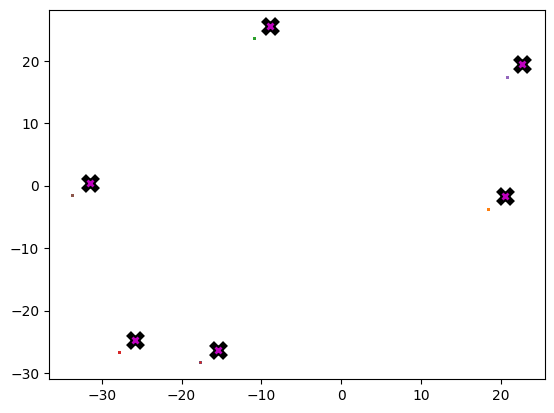

In [36]:
#| echo: false
#| output: false
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
X = data.clone()
fig, ax = plt.subplots()
anime = FuncAnimation(fig, one_frame, frames=5, interval=500, repeat=False)
HTML(anime.to_jshtml())

In [37]:
#| echo: false
#| output: false
fig = plot_data(centroids+2, X, n_samples, display=False);

In [38]:
#| echo: false
#| output: false
fig.data

(Scatter({
     'marker': {'color': '#636EFA', 'size': 3},
     'mode': 'markers',
     'name': 'cluster 0',
     'x': array([-17.709362, -17.709507, -17.709639, ..., -17.71935 , -17.719372,
                 -17.719395], dtype=float32),
     'y': array([-28.32241 , -28.322418, -28.322428, ..., -28.321331, -28.321331,
                 -28.32133 ], dtype=float32)
 }),
 Scatter({
     'marker': {'color': 'black', 'size': 15, 'symbol': 'x'},
     'mode': 'markers',
     'name': 'centroid 0',
     'showlegend': False,
     'x': [-15.466012954711914],
     'y': [-26.38820457458496]
 }),
 Scatter({
     'marker': {'color': 'red', 'size': 7, 'symbol': 'x'},
     'mode': 'markers',
     'name': 'centroid 0',
     'showlegend': False,
     'x': [-15.466012954711914],
     'y': [-26.38820457458496]
 }),
 Scatter({
     'marker': {'color': '#EF553B', 'size': 3},
     'mode': 'markers',
     'name': 'cluster 1',
     'x': array([18.456274, 18.456278, 18.456282, ..., 18.456661, 18.456665, 18.456665]

In [39]:
#| column: page
X = data.clone()
fig = plot_data(centroids+2, X, n_samples, display=False)
fig.update_layout(xaxis_range=[-40, 40], yaxis_range=[-40, 40],  updatemenus=[dict(type='buttons', buttons=[
    dict(label='Play', method='animate', args=[None]),
    dict(label='Pause', method='animate', args=[[None], dict(frame_duration=0, frame_redraw='False', mode='immediate', transition_duration=0)])
])])

frames = [go.Frame(data=fig.data)]
for _ in range(5):
    update(X)
    frames.append(go.Frame(data=plot_data(centroids+2, X, n_samples, display=False).data))
fig.frames = frames
fig.show()

:::{.content-hidden}
### Triangular Kernel instead of Guassian Kernel
:::

## Optimized Implementation

The implementation above is roughly 1.5s which is slow. Let's perform the algorithm on multiple data points simulataneously. We'll then move the operations onto the GPU.

### Calculate Distances

> For each data point $x$ in the dataset, calculate the distance between $x$ and every other data point in the dataset.

In [40]:
X = data.clone(); X.shape

torch.Size([1500, 2])

We'll begin with a batch size of 8.

In [41]:
bs = 8
x = X[:bs, :]; x

tensor([[-18.425, -32.047],
        [-19.443, -25.795],
        [-19.854, -28.213],
        [-17.302, -29.615],
        [-19.117, -26.414],
        [-15.678, -25.571],
        [-16.908, -26.670],
        [-17.445, -28.512]])

In [42]:
x.shape, X.shape

(torch.Size([8, 2]), torch.Size([1500, 2]))

In [43]:
x[:, None, :].shape, X[None, ...].shape

(torch.Size([8, 1, 2]), torch.Size([1, 1500, 2]))

In [44]:
x[:, None, :] - X[None, ...]

tensor([[[  0.000,   0.000],
         [  1.018,  -6.253],
         [  1.429,  -3.834],
         ...,
         [ 10.646, -28.778],
         [ 13.661, -30.151],
         [ 12.676, -29.856]],

        [[ -1.018,   6.253],
         [  0.000,   0.000],
         [  0.411,   2.419],
         ...,
         [  9.629, -22.525],
         [ 12.644, -23.899],
         [ 11.658, -23.604]],

        [[ -1.429,   3.834],
         [ -0.411,  -2.419],
         [  0.000,   0.000],
         ...,
         [  9.217, -24.944],
         [ 12.232, -26.317],
         [ 11.247, -26.022]],

        ...,

        [[  2.748,   6.476],
         [  3.765,   0.223],
         [  4.177,   2.642],
         ...,
         [ 13.394, -22.302],
         [ 16.409, -23.675],
         [ 15.424, -23.380]],

        [[  1.517,   5.377],
         [  2.535,  -0.875],
         [  2.946,   1.543],
         ...,
         [ 12.164, -23.401],
         [ 15.179, -24.774],
         [ 14.193, -24.479]],

        [[  0.980,   3.535],
       

In [45]:
(x[:, None, :] - X[None, ...]).shape

torch.Size([8, 1500, 2])

In [46]:
dists = (x[:, None, :] - X[None, ...]).square().sum(dim=-1).sqrt(); dists, dists.shape

(tensor([[ 0.000,  6.335,  4.092,  ..., 30.684, 33.102, 32.436],
         [ 6.335,  0.000,  2.453,  ..., 24.497, 27.037, 26.326],
         [ 4.092,  2.453,  0.000,  ..., 26.592, 29.021, 28.349],
         ...,
         [ 7.034,  3.772,  4.942,  ..., 26.015, 28.806, 28.010],
         [ 5.587,  2.682,  3.326,  ..., 26.373, 29.054, 28.296],
         [ 3.668,  3.373,  2.427,  ..., 27.792, 30.378, 29.653]]),
 torch.Size([8, 1500]))

In [47]:
#| echo: false
#| output: false
%timeit (x[:, None, :] - X[None, ...]).square().sum(dim=-1).sqrt()

252 µs ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


:::{.content-hidden}
However, these is a much more optimized way to do this through einsum notation.

Not actually.
:::

In [48]:
#| echo: false
#| output: false
torch.einsum('ijk, ijk -> ij', x[:, None, :] - X[None, ...], x[:, None, :] - X[None, ...]).sqrt()

tensor([[ 0.000,  6.335,  4.092,  ..., 30.684, 33.102, 32.436],
        [ 6.335,  0.000,  2.453,  ..., 24.497, 27.037, 26.326],
        [ 4.092,  2.453,  0.000,  ..., 26.592, 29.021, 28.349],
        ...,
        [ 7.034,  3.772,  4.942,  ..., 26.015, 28.806, 28.010],
        [ 5.587,  2.682,  3.326,  ..., 26.373, 29.054, 28.296],
        [ 3.668,  3.373,  2.427,  ..., 27.792, 30.378, 29.653]])

In [49]:
#| echo: false
#| output: false
%timeit torch.einsum('ijk, ijk -> ij', x[:, None, :] - X[None, ...], x[:, None, :] - X[None, ...]).sqrt()

347 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Calculate Weights

> Calculate weights for each point in the dataset by passing the calculated distances through the normal distribution.

We can  simplify the guassian kernel to a triangular kernel and still achieve the same results, with less computation.

In [50]:
plot_func(partial(gauss_kernel, mean=0, std=2.5))

In [51]:
def tri_kernel(x, bw): return (-x+bw).clamp_min(0)/bw
plot_func(partial(tri_kernel, bw=8))

In [52]:
#| echo: false
#| output: false
def egauss_kernel(x, mean, std):
  diff = x - mean
  return torch.exp(-torch.einsum('ij, ij -> ij', diff, diff) / (2 * std ** 2)) / (std * torch.sqrt(2 * tensor(torch.pi)))

egauss_kernel(dists, mean=0, std=2.5)

tensor([[    0.160,     0.006,     0.042,  ...,     0.000,     0.000,     0.000],
        [    0.006,     0.160,     0.099,  ...,     0.000,     0.000,     0.000],
        [    0.042,     0.099,     0.160,  ...,     0.000,     0.000,     0.000],
        ...,
        [    0.003,     0.051,     0.023,  ...,     0.000,     0.000,     0.000],
        [    0.013,     0.090,     0.066,  ...,     0.000,     0.000,     0.000],
        [    0.054,     0.064,     0.100,  ...,     0.000,     0.000,     0.000]])

In [53]:
%timeit gauss_kernel(dists, mean=0, std=2.5)

332 µs ± 27.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [54]:
%timeit tri_kernel(dists, bw=8)

24.6 µs ± 656 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [55]:
gauss_kernel(dists, mean=0, std=2.5), tri_kernel(dists, bw=8)

(tensor([[    0.160,     0.006,     0.042,  ...,     0.000,     0.000,     0.000],
         [    0.006,     0.160,     0.099,  ...,     0.000,     0.000,     0.000],
         [    0.042,     0.099,     0.160,  ...,     0.000,     0.000,     0.000],
         ...,
         [    0.003,     0.051,     0.023,  ...,     0.000,     0.000,     0.000],
         [    0.013,     0.090,     0.066,  ...,     0.000,     0.000,     0.000],
         [    0.054,     0.064,     0.100,  ...,     0.000,     0.000,     0.000]]),
 tensor([[1.000, 0.208, 0.489,  ..., 0.000, 0.000, 0.000],
         [0.208, 1.000, 0.693,  ..., 0.000, 0.000, 0.000],
         [0.489, 0.693, 1.000,  ..., 0.000, 0.000, 0.000],
         ...,
         [0.121, 0.529, 0.382,  ..., 0.000, 0.000, 0.000],
         [0.302, 0.665, 0.584,  ..., 0.000, 0.000, 0.000],
         [0.542, 0.578, 0.697,  ..., 0.000, 0.000, 0.000]]))

In [56]:
ws = tri_kernel(dists, bw=8); ws.shape

torch.Size([8, 1500])

In [57]:
#| echo: false
#| output: false
%timeit gauss_kernel(dists, mean=0, std=2.5)

208 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [58]:
#| echo: false
#| output: false
%timeit egauss_kernel(dists, mean=0, std=2.5)

223 µs ± 9.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Move the Points

> Calculate the weighted average for all points in the dataset. This weighted average is the new location for $x$

In [59]:
ws.shape, X.shape

(torch.Size([8, 1500]), torch.Size([1500, 2]))

In [60]:
ws[..., None].shape, X[None, ...].shape

(torch.Size([8, 1500, 1]), torch.Size([1, 1500, 2]))

In [61]:
(ws[..., None] * X[None, ...]).shape

torch.Size([8, 1500, 2])

In [62]:
(ws[..., None] * X[None, ...]).sum(1).shape

torch.Size([8, 2])

In [63]:
%timeit (ws[..., None] * X[None, ...]).sum(1)

125 µs ± 32.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Let's have another look at formula for weighted average.

$$
\frac{\sum wx}{\sum w}
$$

The numerator is actually the [definition](https://en.wikipedia.org/wiki/Matrix_multiplication#Definition) for matrix multiplication! Therefore we can speed up the operation above by using the `@` operator!

In [64]:
%timeit ws @ X

7.63 µs ± 177 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


A roughly 40% speed up!

In [65]:
x = (ws @ X) / ws.sum(dim=1, keepdim=True); x

tensor([[-17.857, -29.269],
        [-18.770, -27.550],
        [-18.924, -28.182],
        [-17.472, -28.638],
        [-18.472, -27.755],
        [-16.909, -27.610],
        [-17.338, -27.890],
        [-17.535, -28.359]])

In [66]:
#| echo: false
#| output: false
torch.einsum('ik, kj -> ij', ws, X)

tensor([[-1972.012, -3232.406],
        [-2599.328, -3815.141],
        [-3005.563, -4475.949],
        [-2763.261, -4529.361],
        [-2768.782, -4160.239],
        [-2081.435, -3398.707],
        [-2644.484, -4253.982],
        [-2916.516, -4716.696]])

In [67]:
#| echo: false
#| output: false
(torch.einsum('ik, kj -> ij', ws, X) / torch.einsum('ij -> i', ws)[..., None]).shape

torch.Size([8, 2])

And there you have it! We performed this algorithm on 8 data points simultaneously!

Let's encapsulate the code so we can perform it over all data points and time it.

In [68]:
?slice

In [69]:
bs

8

In [70]:
min(1508, 1500)

1500

In [71]:
X = data.clone()
n = len(data)
bs = 8
for i in range(0, n, bs):
    s = slice(i, min(i+bs, n))
    dists = (X[s][:, None, :] - X[None, ...]).square().sum(dim=-1).sqrt()
    ws = egauss_kernel(dists, mean=0, std=2.5)
    X[s] = (ws @ X) / ws.sum(dim=1, keepdim=True)

In [72]:
plot_data(centroids+2, X, n_samples)

In [73]:
def update(X):
  for i in range(0, n, bs):
    s = slice(i, min(i+bs, n))
    dists = (X[s][:, None, :] - X[None, ...]).square().sum(dim=-1).sqrt()
    ws = egauss_kernel(dists, mean=0, std=2.5)
    X[s] = (ws @ X) / ws.sum(dim=1, keepdim=True)

def meanshift(data):
   X = data.clone()
   for _ in range(5): update(X)
   return X

In [74]:
plot_data(centroids+2, meanshift(data), n_samples)

In [75]:
%timeit -n 10 meanshift(data)

610 ms ± 44.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


From 1.5 seconds to 0.5 seconds! A 3x speed increase — very nice!

Let's move onto the GPU and now see what improvements we get.

In [76]:
def meanshift(data):
   X = data.clone().to('cuda')
   for _ in range(5): update(X)
   return X.detach().cpu()

%timeit -n 10 meanshift(data)

254 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


0.5s to 0.25s — a 2x speed increase!

:::{.content-hidden}
## DBScan
:::

:::{.content-hidden}
1. A random sample is selected
2. If the sample has a minimum number of close neighbors, it is considered part of a cluster
3. Step 2 is repeated recursively for all of the sample's close neighbors, and then neighbor's close neighbors, etc. These samples are the cluster's core members.
4. Once Step 3 runs out of samples, a new unvisited sample is selected and the whole process begins again

Afterwards, samples not already assigned to a cluster are assigned to a nearby cluster or marked as outliers.
:::

:::{.content-hidden}
### Select Random Sample
:::

In [77]:
#| echo: false
#| output: false
X = data.clone().to('cpu'); X[0], X[1]

(tensor([-18.425, -32.047]), tensor([-19.443, -25.795]))

In [78]:
#| echo: false
#| output: false
torch.manual_seed(7)
idx = torch.randint(0, len(data), (1, 1)).item()
x = X[idx]; idx, x

(615, tensor([-15.887,  25.419]))

:::{.content-hidden}
### Calculate Distance of It to All Other Samples
:::

In [79]:
#| echo: false
#| output: false
dists = (x - X).square().sum(dim=1).sqrt(); dists

tensor([57.522, 51.337, 53.779,  ..., 31.573, 31.758, 31.525])

In [80]:
#| echo: false
#| output: false
dists = torch.einsum('ij, ij -> i', x - X, x - X).sqrt(); dists

tensor([57.522, 51.337, 53.779,  ..., 31.573, 31.758, 31.525])

:::{.content-hidden}
### Select _k_ Nearest Samples
:::

In [81]:
#| echo: false
#| output: false
?torch.sort

In [82]:
#| echo: false
#| output: false
k = 4
r = 2
dists, idxs = torch.sort(dists); dists, idxs

(tensor([ 0.000,  1.161,  1.342,  ..., 59.812, 60.076, 60.540]),
 tensor([615, 518, 623,  ..., 231, 223, 892]))

In [83]:
#| echo: false
#| output: false
idxs[dists < r]

tensor([615, 518, 623, 578, 704, 713, 612, 722])

In [84]:
#| echo: false
#| output: false
idxs[dists < r][1:k+1]

tensor([518, 623, 578, 704])

In [85]:
#| echo: false
#| output: false
nns = idxs[dists < r][1:k+1]; nns

tensor([518, 623, 578, 704])

In [86]:
#| echo: false
#| output: false
clstr = [nns]

In [87]:
#| echo: false
#| output: false
torch.isin(X[nns], X)

tensor([[True, True],
        [True, True],
        [True, True],
        [True, True]])

In [88]:
#| echo: false
#| output: false
mask = torch.isin(X, X[nns])
X[~mask[:, 0]].shape

torch.Size([1496, 2])

:::{.content-hidden}
### In Loop Form
:::

In [89]:
#| echo: false
#| output: false
?torch.argmin

In [90]:
#| echo: false
#| output: false
x = tensor([1, 2, 3])
for _ in x:
    x = torch.cat((x, tensor([4])))
    print(_)

tensor(1)
tensor(2)
tensor(3)


In [91]:
#| echo: false
#| output: false
import plotly.graph_objects as go

# torch.manual_seed(7)
X = data.clone()
k = 10
r = 5
clstrs = []
outs = tensor([])

while True:
  clstr = []
  idx = torch.randint(0, len(X), (1, 1)).item()
  x = X[[idx]]

  dists = (x - X).square().sum(dim=1).sqrt()
  dists, idxs = torch.sort(dists)

  if (dists <= r).sum(()) >= k:
    clstr.append(x)

    nns = idxs[dists <= r][1:k+1].tolist()

    for nn in nns:
      x = X[[nn]]
      clstr.append(x)
      dists = (x - X).square().sum(dim=1).sqrt()
      dists, idxs = torch.sort(dists)

      if len(idxs[dists <= r]) >= k:
        new_nns = idxs[dists <= r][1:k+1]
        mask = torch.isin(new_nns, tensor(nns))
        new_nns = new_nns[~mask]
        nns.extend(new_nns.tolist())
    clstr = torch.stack(clstr, dim=0).squeeze()
    clstrs.append(clstr)
    mask = torch.isin(X, clstr)
    X = X[~mask[:, 0]]
  else:
    outs = torch.cat((outs, x))
    mask = torch.isin(X, outs)
    X = X[~mask[:, 0]]

  if len(X) == 0: break


In [92]:
#| echo: false
#| output: false
print(len(clstrs))
for clstr in clstrs:
    print(len(clstr))

5
499
251
251
250
249


In [93]:
#| echo: false
#| output: false
clstrs[0], clstrs[0].shape

(tensor([[-32.411, -32.822],
         [-30.862, -32.326],
         [-30.962, -30.800],
         [-30.662, -30.371],
         [-31.259, -29.936],
         [-30.920, -30.081],
         [-29.369, -31.518],
         [-30.602, -29.675],
         [-31.249, -29.369],
         [-30.348, -29.783],
         [-31.100, -28.946],
         [-32.411, -32.822],
         [-29.507, -29.863],
         [-29.047, -30.123],
         [-30.293, -29.156],
         [-30.228, -29.043],
         [-31.037, -28.714],
         [-30.542, -28.850],
         [-28.004, -30.686],
         [-28.942, -29.838],
         [-28.944, -29.756],
         [-27.566, -31.240],
         [-27.979, -30.330],
         [-30.358, -28.043],
         [-29.251, -29.167],
         [-28.706, -29.666],
         [-29.403, -28.961],
         [-30.014, -28.505],
         [-29.682, -28.602],
         [-30.727, -27.615],
         [-30.590, -27.617],
         [-27.130, -30.870],
         [-27.257, -30.055],
         [-27.025, -30.679],
         [-27.

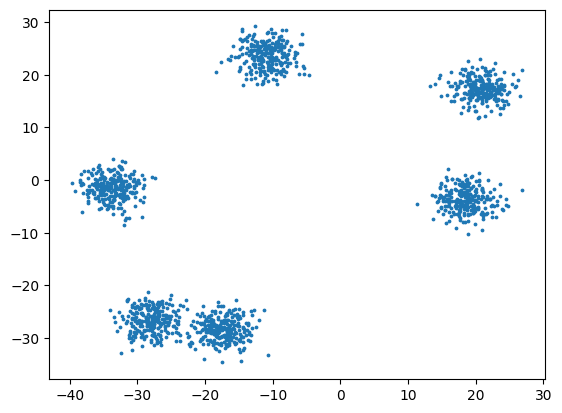

In [94]:
#| echo: false
#| output: false
plt.scatter(data[:, 0], data[:, 1], s=3)

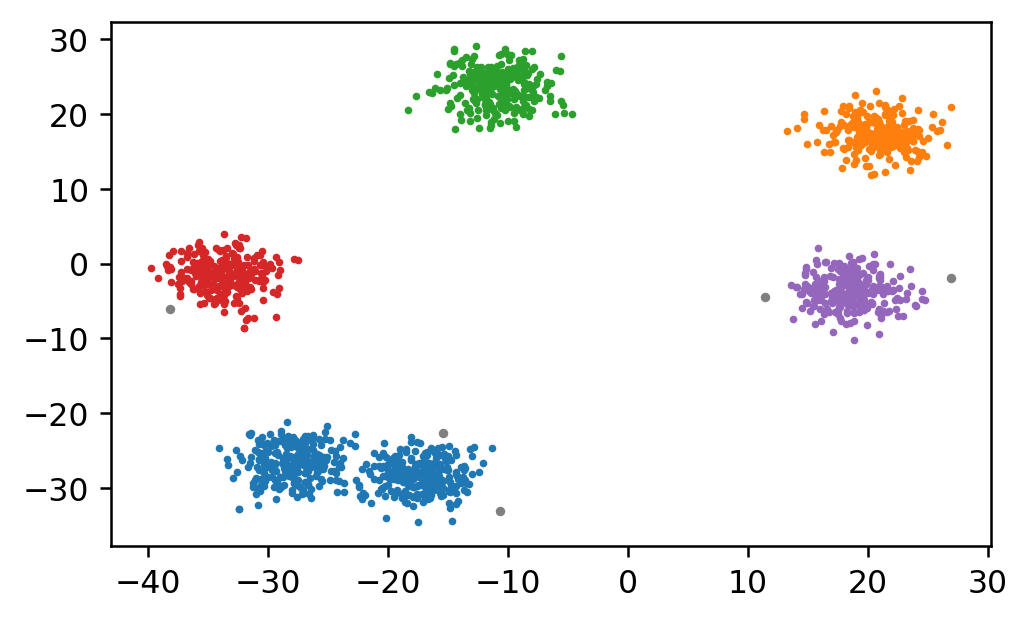

In [95]:
#| echo: false
#| output: false
fig, ax = plt.subplots(figsize=(5, 3), dpi=227)
for clstr in clstrs:
  ax.scatter(clstr[:, 0], clstr[:, 1], s=2)
ax.scatter(outs[:, 0], outs[:, 1], c='grey', s=4)


In [96]:
#| echo: false
#| output: false
import plotly.graph_objects as go

# data = [{'type': 'scatter', 'x': clstr[:, 0], 'y': clstr[:, 1], 'mode': 'markers', 'marker': {'size': 4}} for clstr in clstrs]
# data[0].update({'type': 'scatter', 'x': outs[:, 0], 'y': outs[:, 1], 'mode': 'markers', 'marker': {'size': 6, 'color':'black'}})

In [97]:
#| echo: false
#| output: false

layout = go.Layout(
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None])])]
)

In [98]:
#| echo: false
#| output: false
init = data=[go.Scatter(x=data[:, 0], y=data[:, 1])]

In [99]:
#| echo: false
#| output: false
?go.Scatter

In [100]:
#| echo: false
#| output: false
fig = go.Figure(data=init, frames=frames, layout=layout)
fig.show()

In [101]:
#| echo: false
#| output: false
import plotly.graph_objects as go
import plotly.subplots as sp
import torch
from torch import tensor

# Set up initial figure and empty frames
fig = go.Figure()
frames = []

# torch.manual_seed(7)
X = data.clone()
k = 10
r = 5
clstrs = []
outs = tensor([])

while True:
    clstr = []
    idx = torch.randint(0, len(X), (1, 1)).item()
    x = X[[idx]]

    dists = (x - X).square().sum(dim=1).sqrt()
    dists, idxs = torch.sort(dists)

    if (dists <= r).sum(()) >= k:
        clstr.append(x)
        # Create a scatter plot for the current iteration
        scatter = go.Scatter(
        x=clstrs[-1][:, 0].tolist(),
        y=clstrs[-1][:, 1].tolist(),
        mode='markers',
        marker=dict(size=5)
        )

         # Append the scatter plot to the current frame
        frames.append(go.Frame(data=[scatter]))

        nns = idxs[dists <= r][1:k + 1].tolist()

        for nn in nns:
            x = X[[nn]]
            clstr.append(x)
            scatter = go.Scatter(
            x=clstrs[-1][:, 0].tolist(),
            y=clstrs[-1][:, 1].tolist(),
            mode='markers',
            marker=dict(size=5)
            )

            # Append the scatter plot to the current frame
            frames.append(go.Frame(data=[scatter]))
            dists = (x - X).square().sum(dim=1).sqrt()
            dists, idxs = torch.sort(dists)

            if len(idxs[dists <= r]) >= k:
                new_nns = idxs[dists <= r][1:k + 1]
                mask = torch.isin(new_nns, tensor(nns))
                new_nns = new_nns[~mask]
                nns.extend(new_nns.tolist())
        clstr = torch.stack(clstr, dim=0).squeeze()
        clstrs.append(clstr)
        mask = torch.isin(X, clstr)
        X = X[~mask[:, 0]]
    else:
        outs = torch.cat((outs, x))
        mask = torch.isin(X, outs)
        X = X[~mask[:, 0]]

    if len(X) == 0:
        break

# Add the frames to the figure
fig.frames = frames

# Set layout and initial frame
layout = dict(
    title='Cluster Animation',
    updatemenus=[dict(
        type="buttons",
        buttons=[dict(label="Play", method="animate", args=[None])])
    ]
)

# Check if X is not empty before setting the axis ranges
if len(X) > 0:
    layout["xaxis"] = dict(range=[X[:, 0].min().item() - 1, X[:, 0].max().item() + 1])
    layout["yaxis"] = dict(range=[X[:, 1].min().item() - 1, X[:, 1].max().item() + 1])

fig.update_layout(layout)
fig.show()


AttributeError: ignored